# Three RCMS full historical period

31st October 2023

In [60]:
import pandas as pd
import gpflow
import sys
sys.path.append(
    '/Users/kenzatazi/Documents/CDT/Code/guepard_repo/')
sys.path.append(
    '/Users/kenzatazi/Documents/CDT/Code')
import guepard
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from utils.areal_plots import mean_ci_plots

## Data

In [34]:
dir = '/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/'
df1 = pd.read_csv(
    dir + 'data/processed/hist_MPI_IITM-RegCM4-4.csv', index_col=0)
df2 = pd.read_csv(
    dir + 'data/processed/hist_MPI_REMO2009.csv', index_col=0)
df3 = pd.read_csv('data/processed/hist_CSIRO_IITM-RegCM4-4.csv', index_col=0)

In [89]:
df3= df3[df3['bnds']==0]

In [162]:
df = pd.concat([df1, df2, df3])
df = df[df['time'] >= '1976-01-01']
df.sort_values(by=['lat', 'lon', 'time'], inplace=True)
df[:129600]

,time,lon,lat,bnds,time_bnds,tp,nb2
0,1976-01-01,60.25,20.25,0.0,1976-01-01,1.047324,NaN
120,1976-01-01,60.25,20.25,NaN,1976-01-01,0.116045,0.0
0,1976-01-01,60.25,20.25,0.0,1976-01-01 00:00:00,0.395135,NaN
7200,1976-02-01,60.25,20.25,0.0,1976-02-01,0.537998,NaN
122,1976-02-01,60.25,20.25,NaN,1976-02-01,0.074725,0.0
...,...,...,...,...,...,...,...
1244196,1977-07-01,78.75,20.75,NaN,1977-07-01,12.553898,0.0
132562,1977-07-01,78.75,20.75,0.0,1977-07-01 00:00:00,6.315406,NaN
139762,1977-08-01,78.75,20.75,0.0,1977-08-01,9.227697,NaN
1244198,1977-08-01,78.75,20.75,NaN,1977-08-01,3.065373,0.0


In [167]:
df['lat_group'] = pd.cut(df['lat'], 40, labels=np.arange(40))
df['lon_group'] = pd.cut(df['lon'], 90, labels=np.arange(90))


In [133]:
df['time'] = pd.to_numeric(pd.to_datetime(df['time']))
# Make sure the data is sorted


In [168]:
df.groupby(['lat_group', 'lon_group'])


In [135]:
input_scaler = StandardScaler()
input_scaler.fit(df[['time', 'lon', 'lat']])
in_arr = input_scaler.transform(df[['time', 'lon', 'lat']])

In [136]:
out_arr_tr, lmbd = boxcox(df['tp'].values+0.001)
df['tp_tr'] = out_arr_tr

In [137]:
output_scaler = StandardScaler()
output_scaler.fit(df[['tp_tr']])
out_arr = output_scaler.transform(df[['tp_tr']])

In [139]:
out_arr.shape[0]

3672000

## Model

In [143]:
# seperate x and y
num_split = 150

# list of num_split np.arrays
Xl = np.array_split(in_arr[:129600], num_split)
Yl = np.array_split(out_arr[:129600], num_split)

kernel = gpflow.kernels.Matern32()
noise_var = 0.01

In [144]:
# list of num_split GPR models
submodels = guepard.utilities.get_gpr_submodels(
    zip(Xl, Yl), kernel, noise_variance=noise_var)

In [145]:
m_rbcm = guepard.baselines.Ensemble(
    models=submodels, method=guepard.baselines.EnsembleMethods.RBCM, weighting=guepard.baselines.WeightingMethods.VAR)

In [146]:
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m_rbcm.training_loss,
                        m_rbcm.trainable_variables, options=dict(maxiter=100))
gpflow.utilities.print_summary(m_rbcm)

╒══════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                                     │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞══════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Ensemble.kernel.variance                 │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.57107 │
│ Ensemble.models[0].kernel.variance       │           │                  │         │             │         │         │         │
│ Ensemble.models[1].kernel.variance       │           │                  │         │             │         │         │         │
│ Ensemble.models[2].kernel.variance       │           │                  │         │             │         │         │         │
│ Ensemble.models[3].kernel.variance       │           │                  │         │     

In [147]:
#remove duplicate rows
x_plot = np.unique(np.array(Xl).reshape(-1, 3), axis=0)
x_plot.shape

(43200, 3)

In [148]:
ypred, var = m_rbcm.predict_y(x_plot)
arr= np.stack((ypred.numpy().flatten(), var.numpy().flatten()), axis=1)

In [149]:
df_temp= pd.DataFrame(arr, columns=['pred0', 'var0'])

In [150]:
input_loc_arr = input_scaler.inverse_transform(np.array(x_plot).reshape(-1, 3))

In [151]:
# Create dataframe, apply inverse transform and calculate 95th percentile CI
df_temp['y_pred'] = output_scaler.inverse_transform(inv_boxcox(
    df_temp['pred0'].values.reshape(-1, 1), lmbd))
df_temp['95th_u'] = output_scaler.inverse_transform(inv_boxcox(
    df_temp['pred0'].values.reshape(-1, 1) + 1.96 * np.sqrt(df_temp['var0'].values.reshape(-1, 1)), lmbd))
df_temp['95th_l'] = output_scaler.inverse_transform(inv_boxcox(
    df_temp['pred0'].values.reshape(-1, 1) - 1.96 * np.sqrt(df_temp['var0'].values.reshape(-1, 1)), lmbd))
df_temp['CI'] = df_temp['95th_u'].fillna(0) - df_temp['95th_l'].fillna(0)

df_temp[['time', 'lon', 'lat']] = input_loc_arr
df_temp.set_index(['time', 'lon', 'lat'], inplace=True)

df_temp[['y_pred', '95th_u', '95th_l', 'CI']] = df_temp[[
    'y_pred', '95th_u', '95th_l', 'CI']].fillna(0)

In [152]:
df_temp.to_csv('data/outputs/rbcm_tr_3rcm_1961_1965.csv')

In [153]:
df_temp

pred0      var0    y_pred    95th_u    95th_l  \
time         lon    lat                                                       
1.893024e+17 60.25  20.25 -0.930150  0.363342  0.623156  2.109975  0.148594   
                    20.75 -0.940740  0.362295  0.615614  2.086187  0.147052   
                    21.25 -0.954856  0.362163  0.605681  2.058730  0.144679   
                    21.75 -0.982906  0.362173  0.586351  2.005848  0.140036   
                    22.25 -0.979810  0.362318  0.588458  2.012076  0.140500   
...                             ...       ...       ...       ...       ...   
2.182464e+17 104.75 37.75 -0.263773  0.362321  1.281843  3.755579  0.337627   
                    38.25 -0.370355  0.362176  1.149017  3.438921  0.296049   
                    38.75 -0.505102  0.362167  0.997389  3.069883  0.250409   
                    39.25 -0.582535  0.362299  0.917971  2.872985  0.227365   
                    39.75 -0.620912  0.363347  0.880591  2.783049  0.216335   

                                 CI  
time         lon    lat              
1.893024e+17 60.25  20.25  1.961381  
                    20.75  1.939135  
                    21.25  1.914050  
                    21.75  1.865812  
                    22.25  1.871576  
...                             ...  
2.182464e+17 104.75 37.75  3.417952  
                    38.25  3.142873  
                    38.75  2.819473  
                    39.25  2.645620  
                    39.75  2.566714  

[43200 rows x 6 columns]

In [156]:
# To Data Array
ds = df_temp.to_xarray()
#ds['time'] = ds['time'].astype('datetime64[ns]')
ds

<xarray.Dataset>
Dimensions:  (time: 12, lon: 90, lat: 40)
Coordinates:
  * time     (time) float64 1.893e+17 1.92e+17 1.945e+17 ... 2.157e+17 2.182e+17
  * lon      (lon) float64 60.25 60.75 61.25 61.75 ... 103.2 103.8 104.2 104.8
  * lat      (lat) float64 20.25 20.75 21.25 21.75 ... 38.25 38.75 39.25 39.75
Data variables:
    pred0    (time, lon, lat) float64 -0.9302 -0.9407 ... -0.5825 -0.6209
    var0     (time, lon, lat) float64 0.3633 0.3623 0.3622 ... 0.3623 0.3633
    y_pred   (time, lon, lat) float64 0.6232 0.6156 0.6057 ... 0.918 0.8806
    95th_u   (time, lon, lat) float64 2.11 2.086 2.059 ... 3.07 2.873 2.783
    95th_l   (time, lon, lat) float64 0.1486 0.1471 0.1447 ... 0.2274 0.2163
    CI       (time, lon, lat) float64 1.961 1.939 1.914 ... 2.819 2.646 2.567

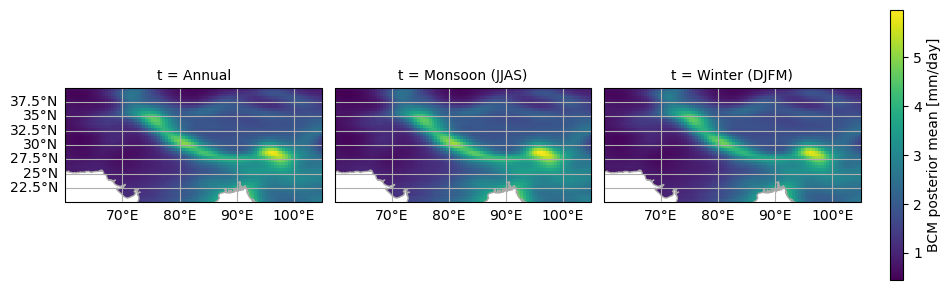

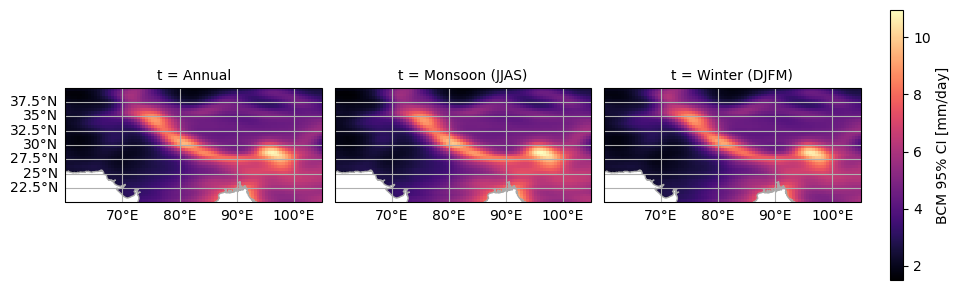

In [157]:
mean_ci_plots(ds)